# Resterampe

In [ ]:
issues = list(filter(lambda issue: issue.created_at >= start_date , repo.get_issues(state='all')))

In [9]:
#issues_relevant = issues_dataframe[issues_dataframe.closed_at.isnull() | (issues_dataframe.closed_at > start_date)]
#issues_relevant

In [5]:
test_issue = repo.get_issues(state='all')[0]

In [22]:
dir(test_issue)

['CHECK_AFTER_INIT_FLAG',
 '_CompletableGithubObject__complete',
 '_CompletableGithubObject__completed',
 '_GithubObject__makeSimpleAttribute',
 '_GithubObject__makeSimpleListAttribute',
 '_GithubObject__makeTransformedAttribute',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_active_lock_reason',
 '_assignee',
 '_assignees',
 '_body',
 '_closed_at',
 '_closed_by',
 '_comments',
 '_comments_url',
 '_completeIfNeeded',
 '_completeIfNotSet',
 '_created_at',
 '_events_url',
 '_headers',
 '_html_url',
 '_id',
 '_identity',
 '_initAttributes',
 '_labels',
 '_labels_url',
 '_locked',
 '_makeBoolAttribute',
 '_makeClassAttribute',
 '_makeDatetimeAttribute',
 '_makeDictAttr

In [17]:
repo.get_issues.__code__.co_varnames

('self',
 'milestone',
 'state',
 'assignee',
 'mentioned',
 'labels',
 'sort',
 'direction',
 'since',
 'creator',
 'url_parameters')

In [ ]:
issues_open_per_sprint = [0] * len(sprint_range)
issues_open_per_sprint[0] = len(issues_open_at_start)
for i in range(0, len(sprint_range)-1):
    issues_open_per_sprint[i+1] = issues_open_per_sprint[i] + issues.opened[issues.index[0]+i] - issues.closed[issues.index[0]+i]
issues['open_at_start'] = issues_open_per_sprint
issues

In [ ]:
issues_open_at_start = issues_dataframe[(issues_dataframe.created_at < start_date) & (issues_dataframe.closed_at.isnull() | (issues_dataframe.closed_at > start_date))]
issues_open_at_start

In [ ]:
start_date = sprint_to_start_date(start_sprint)
end_date = sprint_to_start_date(end_sprint+1) # +1 because we want the end sprint to be inclusive, so we take the start of the next as interval end
sprint_range = range(start_sprint, end_sprint+1)

In [45]:
pyplot.figure(figsize=(20, 10))
pyplot.bar(groups)

TypeError: bar() missing 1 required positional argument: 'height'

<Figure size 1440x720 with 0 Axes>

## Data Collection and Preprocessing

In [67]:
repo = server_repo

In [68]:
issues_raw = repo.get_issues(state='all')
issues_raw

In [69]:
attributes = ['number', 'title', 'labels', 'created_at', 'closed_at']
issues_dataframe = pandas.DataFrame([[getattr(issue, attr) for attr in attributes] for issue in issues_raw], columns=attributes)
issues_dataframe

,number,title,labels,created_at,closed_at
0,1937,Bump s3 from 2.17.182 to 2.18.0,"[Label(name=""dependencies"")]",2022-10-21 02:11:44,NaT
1,1936,Bump spring-boot.version from 2.7.4 to 2.7.5,"[Label(name=""dependencies"")]",2022-10-21 02:11:41,NaT
2,1935,Bump protobuf.version from 3.21.7 to 3.21.8,"[Label(name=""dependencies"")]",2022-10-19 02:06:39,NaT
3,1934,Feature/allowlist json validation,[],2022-10-18 08:07:19,NaT
4,1933,Bump spring-retry from 1.3.3 to 1.3.4,"[Label(name=""dependencies"")]",2022-10-17 02:04:45,NaT
...,...,...,...,...,...
1909,6,Index File Generation,"[Label(name=""distribution service"")]",2020-04-30 17:55:26,2020-05-14 16:24:46
1910,5,Set Retention Days to 14,[],2020-04-30 17:46:31,2020-05-15 08:11:48
1911,9,Setup Wiki,[],2020-04-28 10:19:38,2020-05-10 08:43:47
1912,2,DDoS protection,[],2020-04-28 10:10:33,2020-05-10 14:58:38


In [70]:
issues_opened_per_sprint = issues_dataframe.groupby(by=(lambda index: date_to_sprint(issues_dataframe.loc[index]['created_at'])))['number'].count().astype('Int64')
issues_closed_per_sprint = issues_dataframe[issues_dataframe.closed_at.notnull()].groupby(by=(lambda index: date_to_sprint(issues_dataframe.loc[index]['closed_at'])))['number'].count().astype('Int64')

In [71]:
issues = pandas.DataFrame(index=range(0, date_to_sprint(datetime.today()))) # The range ensures that there are rows for sprints where no issues were opened or closed
issues = pandas.concat([issues, issues_opened_per_sprint, issues_closed_per_sprint], axis='columns')
issues.index.name = 'sprint'
issues.columns = ['opened', 'closed']
issues = issues.fillna(0) # Replace NaN values from outer join with zero
# issues

In [72]:
issues['open_at_start'] = 0
for sprint in range(1, max(issues.index)+1):
    issues.open_at_start[sprint] = issues.open_at_start[sprint-1] + issues.opened[sprint-1] - issues.closed[sprint-1]
issues

/mnt/d/Users/Leon Bein/Documents/HPI/U_Masterarbeit/masterThesisCode/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,opened,closed,open_at_start
sprint,,,
0,0,0,0
1,60,39,0
2,227,201,21
3,175,199,47
4,137,123,23
...,...,...,...
61,9,10,5
62,10,12,4
63,14,12,2


In [65]:
sprint_to_analyze = 55
issues_dataframe[issues_dataframe.apply(lambda x: date_to_sprint(x.issue.created_at) < sprint_to_analyze and ((x.issue.closed_at is None) or (date_to_sprint(x.issue.closed_at) >= sprint_to_analyze)), axis=1)].apply(lambda x: [x.issue.number, x.issue.title], axis=1)

142    [1797, Failed to instantiate distribution serv...
146                       [1793, Kubernetes deployments]
362    [1575, Quantitative analysis on the CWA code b...
904                [1027, Feature/optimized dockerfiles]
dtype: object

In [58]:
sprint_to_analyze = 64
issues_dataframe[issues_dataframe.apply(lambda x: date_to_sprint(x.issue.created_at) < sprint_to_analyze and ((x.issue.closed_at is None) or (date_to_sprint(x.issue.closed_at) >= sprint_to_analyze)), axis=1)]

,issue
28,"Issue(title=""use PROD values as default"", numb..."
29,"Issue(title=""Feature/json validation"", number=..."
146,"Issue(title=""Kubernetes deployments"", number=1..."
904,"Issue(title=""Feature/optimized dockerfiles"", n..."


# The team

In [6]:
sap = g.get_organization('SAP')
cwa = g.get_organization('corona-warn-app')

In [46]:
list(filter(lambda member: ('SAP' in (member.company or '').upper()) or member.login.upper().endswith('SAP') or sap.has_in_members(member), cwa.get_members()))

[NamedUser(login="AdnanZiSAP"),
 NamedUser(login="christian-kirschnick"),
 NamedUser(login="christianneu"),
 NamedUser(login="EvgeniiSkrebtcov"),
 NamedUser(login="haosap"),
 NamedUser(login="hilmarf"),
 NamedUser(login="inf2381"),
 NamedUser(login="johanneseschrig"),
 NamedUser(login="johannesrohwer"),
 NamedUser(login="MalteJ"),
 NamedUser(login="marcauberer"),
 NamedUser(login="Marco2907"),
 NamedUser(login="mibrasap"),
 NamedUser(login="michael-burwig"),
 NamedUser(login="mlenkeit"),
 NamedUser(login="PetrusVanHeaven"),
 NamedUser(login="pithumke"),
 NamedUser(login="SebastianWolf-SAP"),
 NamedUser(login="steins-code"),
 NamedUser(login="T-Bendrath"),
 NamedUser(login="tkowark")]

In [48]:
list(filter(lambda member: ('SAP' in (member.company or '').upper()) or member.login.upper().endswith('SAP'), cwa.get_members()))

[NamedUser(login="AdnanZiSAP"),
 NamedUser(login="christian-kirschnick"),
 NamedUser(login="christianneu"),
 NamedUser(login="EvgeniiSkrebtcov"),
 NamedUser(login="haosap"),
 NamedUser(login="hilmarf"),
 NamedUser(login="inf2381"),
 NamedUser(login="johanneseschrig"),
 NamedUser(login="johannesrohwer"),
 NamedUser(login="MalteJ"),
 NamedUser(login="marcauberer"),
 NamedUser(login="Marco2907"),
 NamedUser(login="mibrasap"),
 NamedUser(login="michael-burwig"),
 NamedUser(login="mlenkeit"),
 NamedUser(login="PetrusVanHeaven"),
 NamedUser(login="pithumke"),
 NamedUser(login="SebastianWolf-SAP"),
 NamedUser(login="steins-code"),
 NamedUser(login="T-Bendrath"),
 NamedUser(login="tkowark")]

In [ ]:
g.get_user('MalteJ').login

'MalteJ'

In [45]:
g.get_user('SebastianWolf-SAP').company

'@sap'

In [43]:
g.get_user('MalteJ').company

'SAP'

In [42]:
g.get_user('tkowark').company

'@SAP '

In [47]:
g.get_user('johannesrohwer').company

'@SAP '

In [39]:
sap.has_in_members(g.get_user('SebastianWolf-SAP'))

True

In [41]:
def is_customer_issue(issue):
    return issue.user.login not in ['dependabot[bot]', 'Corona-Warn-App-Technical-User'] and issue.user not in server_team and not issue.pull_request

customer_issues = issues_dataframe[issues_dataframe.issue.apply(is_customer_issue)]
customer_issues

,issue
108,"Issue(title=""How are the trend arrows calculat..."
159,"Issue(title=""Failed to instantiate distributio..."
163,"Issue(title=""Kubernetes deployments"", number=1..."
284,"Issue(title=""PROD Server and GitHub repository..."
296,"Issue(title=""Suggestion: Remove JndiLookup.cla..."
...,...
1758,"Issue(title=""Should TAN's really allow SPACE c..."
1774,"Issue(title=""Misleading HTTP Status codes for ..."
1823,"Issue(title=""Hard coded credentials in docker-..."
1877,"Issue(title=""Review the readme template propos..."


In [121]:
issues_per_month = customer_issues.groupby(by=(lambda index: customer_issues.loc[index].issue.created_at.date().replace(day=1)))

<AxesSubplot:xlabel='created_sprint'>

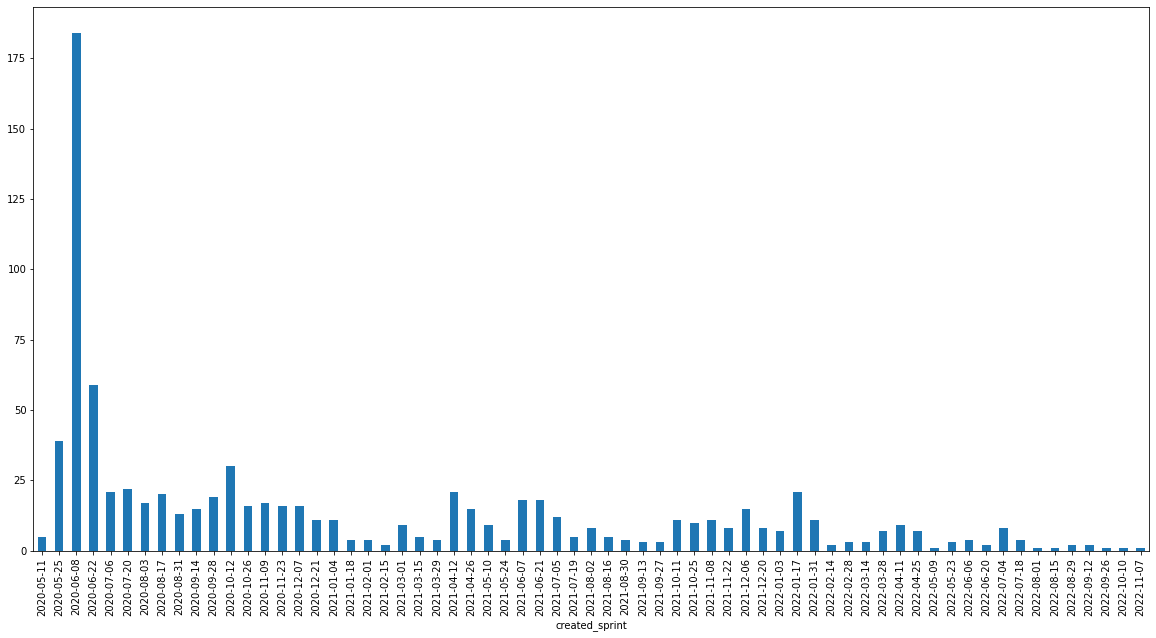

In [19]:
pyplot.figure(figsize=(20, 10))
issues_per_sprint.issue.count().plot.bar()

<AxesSubplot:xlabel='created_sprint'>

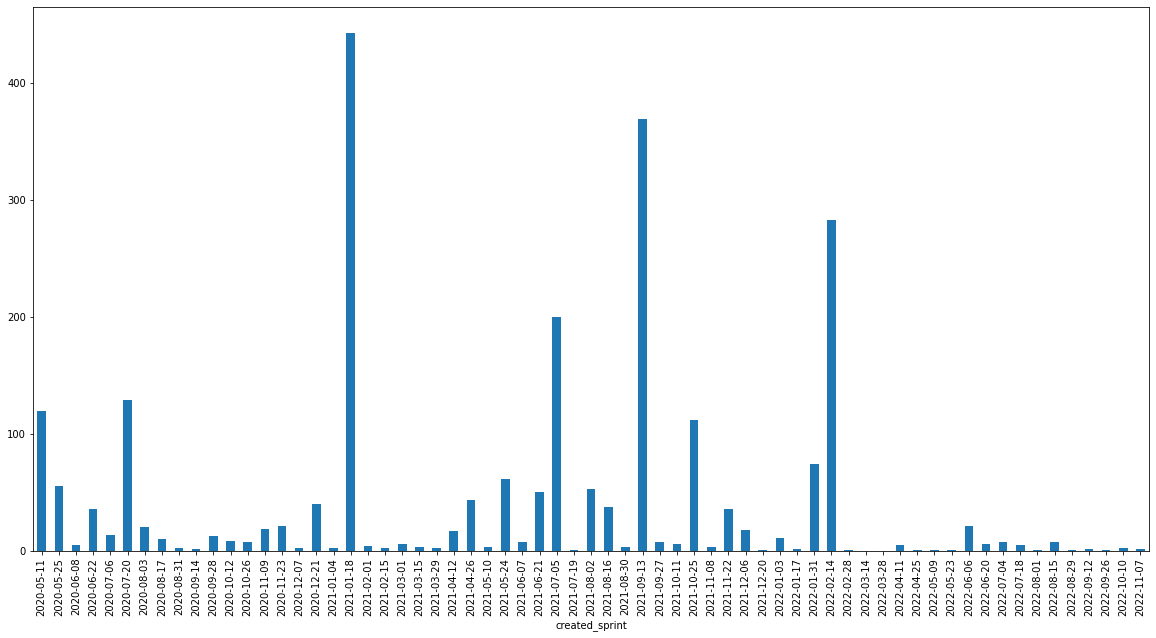

In [20]:
pyplot.figure(figsize=(20, 10))
mean_time_to_react = issues_per_sprint.time_to_react.apply(numpy.mean)
(mean_time_to_react / pandas.Timedelta(hours=1)).plot.bar()

<AxesSubplot:xlabel='created_sprint'>

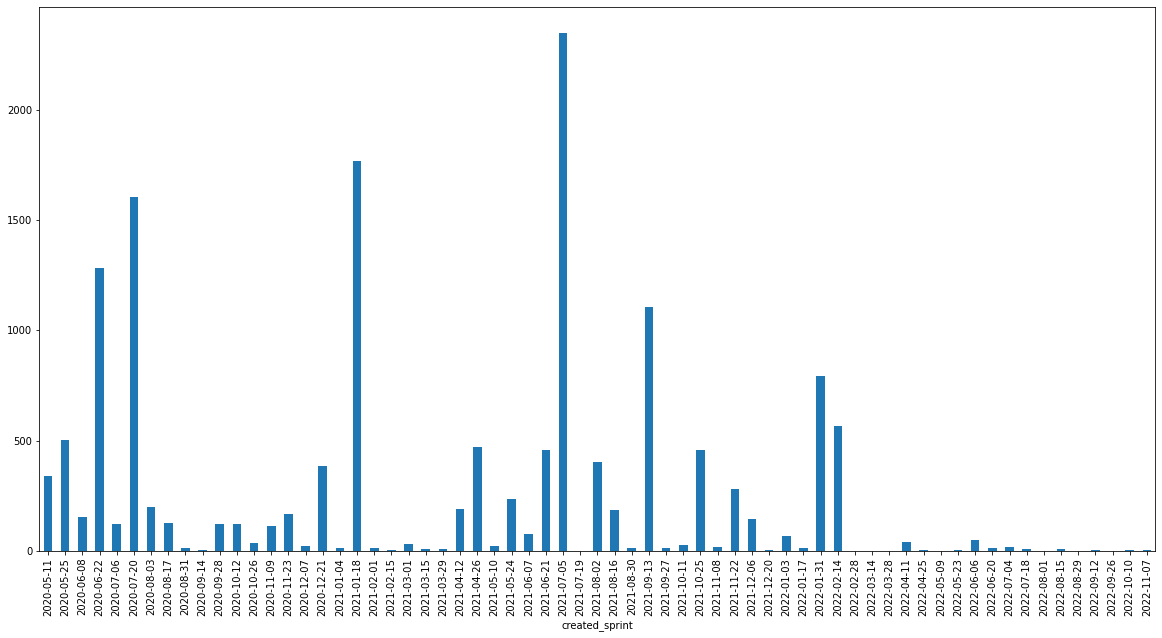

In [21]:
pyplot.figure(figsize=(20, 10))
max_time_to_react = issues_per_sprint.time_to_react.apply(numpy.max)
(max_time_to_react / pandas.Timedelta(hours=1)).plot.bar()

# More ...